# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    ema_logging,
    perform_experiments,
    Scenario,
    HypervolumeMetric,
    GenerationalDistanceMetric,
    EpsilonIndicatorMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)


from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)
from ema_workbench.analysis import parcoords
from problem_formulation import get_model_for_problem_formulation
from MORDM_pyfile import MORDM_function


# Define calculation metrics

In [8]:
def calculate_metrics(archives, reference_set):
    problem = to_problem(dike_model, searchover="levers", reference=reference_scenario)

    hv = HypervolumeMetric(reference_set, problem)
    gd = GenerationalDistanceMetric(reference_set, problem, d=1)
    ei = EpsilonIndicatorMetric(reference_set, problem)
    ig = InvertedGenerationalDistanceMetric(reference_set, problem, d=1)
    sm = SpacingMetric(problem)

    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "generational_distance": gd.calculate(archive),
            "hypervolume": hv.calculate(archive),
            "epsilon_indicator": ei.calculate(archive),
            "inverted_gd": ig.calculate(archive),
            "spacing": sm.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    return metrics


def plot_metrics(metrics, convergence):
    sns.set_style("white")
    fig, axes = plt.subplots(nrows=6, figsize=(8, 12), sharex=True)

    ax1, ax2, ax3, ax4, ax5, ax6 = axes

    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")

    ax3.plot(metrics.nfe, metrics.generational_distance)
    ax3.set_ylabel("generational distance")

    ax4.plot(metrics.nfe, metrics.epsilon_indicator)
    ax4.set_ylabel("epsilon indicator")

    ax5.plot(metrics.nfe, metrics.inverted_gd)
    ax5.set_ylabel("inverted generational\ndistance")

    ax6.plot(metrics.nfe, metrics.spacing)
    ax6.set_ylabel("spacing")

    ax6.set_xlabel("nfe")

    sns.despine(fig)

# Define model and reference scenario

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)

# choose problem formulation number, between 0-5
# each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

# enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
import copy

for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

reference_scenario = Scenario('Reference Scenario', **dict({
    'discount rate 0': 2.5,
    'discount rate 1': 2.5,
    'discount rate 2': 2.5,
    'A.0_ID flood wave shape': 4,
    'A.1_Bmax': 175,
    'A.2_Bmax': 175,
    'A.3_Bmax': 175,
    'A.4_Bmax': 175,
    'A.5_Bmax': 175,
    'A.1_pfail': 0.5,
    'A.2_pfail': 0.5,
    'A.3_pfail': 0.5,
    'A.4_pfail': 0.5,
    'A.5_pfail': 0.5,
    'A.1_Brate': 1.5,
    'A.2_Brate': 1.5,
    'A.3_Brate': 1.5,
    'A.4_Brate': 1.5,
    'A.5_Brate': 1.5
}))

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

# Define convergence metrics and optimization function for reference scenario

In [4]:
convergence_metrics = [ArchiveLogger(
                        "./archives",
                        [l.name for l in dike_model.levers],
                        [o.name for o in dike_model.outcomes],
                        base_filename="optimization_1000x10.tar.gz",
                        ),
                        EpsilonProgress(),
                        ]

In [6]:
nfe = 10000
epsilons = 0.1

results, convergence = MORDM_function(dike_model, reference_scenario, nfe, epsilons, convergence_metrics)

[MainProcess/INFO] pool started with 4 workers
1099it [03:58,  4.62it/s]                                                      
[MainProcess/INFO] optimization completed, found 38 solutions
[MainProcess/INFO] terminating pool


# Calculate metrics to check convergence

In [ ]:
archives = ArchiveLogger.load_archives(f"./archives/test2.tar.gz")
for key in archives:
    if 'Unnamed: 0' in archives[key].columns:
        archives[key] = archives[key].drop(columns=['Unnamed: 0'])
reference_set = archives[max(archives.keys())] # this is the final archive
metrics = calculate_metrics(archives, reference_set)
plot_metrics(metrics, convergence)

plt.show()

# Visualise outcomes

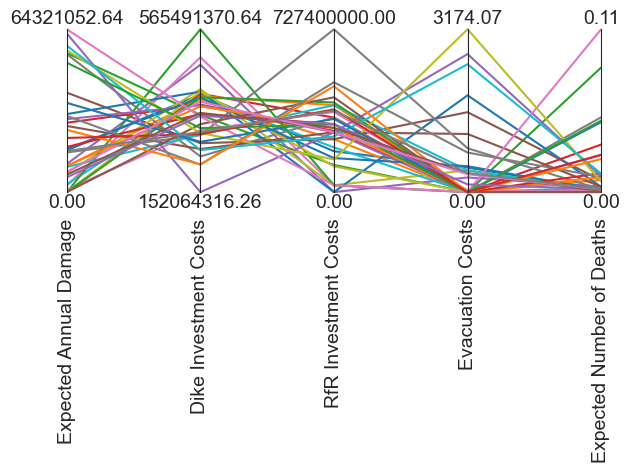

In [9]:
outcomes = results.loc[:, ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

# we invert this axis so direction of desirability is the same 
# axes.invert_axis('Expected Number of Deaths') 
# plt.show()


In [13]:
# Step 1: Sort the dataframe (example sorted by a column 'score')
results_sorted = results.sort_values(by='Expected Annual Damage')

# Step 2: Calculate the number of rows corresponding to 10%
n = len(results_sorted)
percent_count = int(n * 0.1)

# Step 3: Extract the top 10%, bottom 10%, and middle 10%
top_10_percent = results_sorted.head(percent_count)
bottom_10_percent = results_sorted.tail(percent_count)
middle_start = (n // 2) - (percent_count // 2)
middle_end = middle_start + percent_count
middle_10_percent = results_sorted.iloc[middle_start:middle_end]

# Step 4: Concatenate these subsets into a single dataframe
outcomes = pd.concat([top_10_percent, middle_10_percent, bottom_10_percent])

# Reset the index if needed
outcomes = outcomes.reset_index(drop=True)

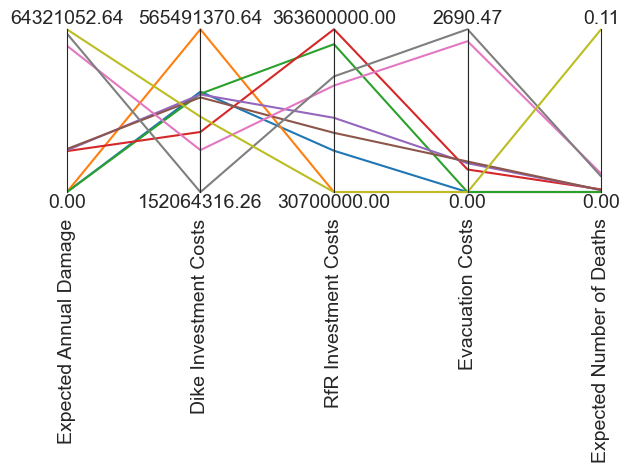

In [16]:
outcomes = outcomes.loc[:, ['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)

In [17]:
import pysmo

In [18]:
import idaes

In [ ]:
idaes.su